<a href="https://colab.research.google.com/github/leeIITM/MY_WORKS/blob/main/vit_for_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision scipy matplotlib


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import scipy.io
import matplotlib.pyplot as plt

In [ ]:
class Caltech101Dataset(Dataset):
    def __init__(self, image_dir, annot_dir, transform=None):
        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.transform = transform

        # List image and annotation files
        self.image_files = sorted(os.listdir(image_dir))
        self.annot_files = sorted(os.listdir(annot_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = read_image(img_path).float() / 255.0  # Normalize to [0, 1]

        # Load annotation
        annot_path = os.path.join(self.annot_dir, self.annot_files[idx])
        annot = scipy.io.loadmat(annot_path)["box_coord"][0]
        top_left_x, top_left_y = annot[2], annot[0]
        bottom_right_x, bottom_right_y = annot[3], annot[1]

        # Relative bounding box coordinates
        box = np.array([
            top_left_x / image.size(2), top_left_y / image.size(1),
            bottom_right_x / image.size(2), bottom_right_y / image.size(1)
        ], dtype=np.float32)

        if self.transform:
            image = self.transform(image)

        return image, box

transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

loading Roboflow workspace...
loading Roboflow project...
Images path: /content/helipad-2/train/images
Annotations path: /content/helipad-2/train/labels


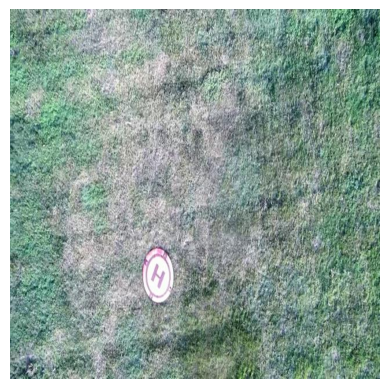

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="EX5EQLCiwLSmjjZIBJkc")
project = rf.workspace("luis-landivar").project("helipad-87jjr")
version = project.version(2)
dataset = version.download("yolov5")

# The dataset is already extracted to the directory specified by `dataset.location`
# No need to unzip.

# Access the images and annotations
images_path = os.path.join(dataset.location, "train", "images")  # Adjusted path
annotations_path = os.path.join(dataset.location, "train", "labels")  # Adjusted path

# Print out the paths
print("Images path:", images_path)
print("Annotations path:", annotations_path)

# Example: Load one image to visualize
import cv2
import matplotlib.pyplot as plt

# Load an image
image_file = os.path.join(images_path, os.listdir(images_path)[0])  # Get the first image
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
image_dir = '/content/helipad-2/train/images'  # Update path
annot_dir = '/content/helipad-2/train/labels'  # Update path

# Dataset and DataLoader
dataset = Caltech101Dataset(image_dir, annot_dir, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

# Custom dataset for object detection
class CustomDataset(Dataset):
    def __init__(self, image_dir, annot_dir, transform=None):
        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load annotations
        annot_name = os.path.join(self.annot_dir, self.images[idx].replace('.jpg', '.txt'))  # Assuming .jpg images
        boxes = []
        with open(annot_name, 'r') as f:
            for line in f.readlines():
                # Assuming annotations are in the format: class x_center y_center width height
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                boxes.append([class_id, x_center, y_center, width, height])

        boxes = np.array(boxes)

        if self.transform:
            image = self.transform(image)

        return image, boxes

# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to the required input size of ViT
    transforms.ToTensor(),
])

# Create dataset and dataloader
image_dir = '/content/helipad-2/train/images'
annot_dir = '/content/helipad-2/train/labels'
dataset = CustomDataset(image_dir, annot_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
!pip install torch torchvision transformers


In [ ]:
from transformers import ViTForObjectDetection, ViTFeatureExtractor

# Load the feature extractor and model
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTForObjectDetection.from_pretrained("google/vit-base-patch16-224", num_labels=2)  # Change num_labels as per your classes


ImportError: cannot import name 'ViTForObjectDetection' from 'transformers' (/usr/local/lib/python3.10/dist-packages/transformers/__init__.py)

In [ ]:
# Define MLP function
def mlp(x, hidden_units):
    for units in hidden_units:
        x = nn.Linear(x.size(1), units)(x)
        x = nn.GELU()(x)
    return x


In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, num_patches, projection_dim, num_heads, transformer_units, transformer_layers, mlp_head_units):
        super(VisionTransformer, self).__init__()
        self.patch_size = 16
        self.num_patches = num_patches
        self.projection = nn.Linear(self.patch_size * self.patch_size * 3, projection_dim)
        self.position_embedding = nn.Embedding(num_patches, projection_dim)
        self.transformer_blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=projection_dim, nhead=num_heads)
            for _ in range(transformer_layers)
        ])
        self.mlp_head = mlp(nn.Linear(projection_dim, projection_dim), mlp_head_units)
        self.bounding_box_head = nn.Linear(mlp_head_units[-1], 4)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(batch_size, -1, self.patch_size * self.patch_size * 3)  # Reshape into patches
        x = self.projection(x) + self.position_embedding(torch.arange(self.num_patches, device=x.device))

        for block in self.transformer_blocks:
            x = block(x)

        x = x.mean(dim=1)  # Global average pooling
        x = self.mlp_head(x)
        bounding_box = self.bounding_box_head(x)
        return bounding_box

In [ ]:
image_size = 224
num_patches = (image_size // 16) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64]

# Model, Loss, Optimizer
model = VisionTransformer(num_patches, projection_dim, num_heads, transformer_units, transformer_layers, mlp_head_units)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0017, weight_decay=0.00012)

# Training Loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    for images, boxes in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, boxes)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluation (optional)
model.eval()
with torch.no_grad():
    for images, boxes in test_loader:
        outputs = model(images)

TypeError: empty(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got Linear"

In [ ]:
import torch.nn as nn

# Define MLP function
def mlp(input_dim, hidden_units):
    layers = []
    current_dim = input_dim  # Start with the initial input dimension

    for units in hidden_units:
        layers.append(nn.Linear(current_dim, units))
        layers.append(nn.GELU())
        current_dim = units  # Update current dimension for the next layer

    return nn.Sequential(*layers)  # Combine layers into a sequential module